In [10]:
import os
import numpy as np
import pandas as pd
import selfies
import glob
import torch
import chemistry_vae_selfies
import data_loader
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from random import sample
import properties_searcher

In [12]:
list_of_properties = []

my_file = pd.read_csv('./datasets/PropsQM9/listprops.csv', index_col=None)##The file you want to train on, should contain SMILES reps, latent space reps and properties
my_file.dropna()


for i in range(len(my_file)):

    DipoleIn = my_file['dipole_moment'][i]
    GapIn = my_file['energy_gap'][i]
    SMILESCodeIn = my_file['smiles'][i]
    list_of_properties.append([SMILESCodeIn, GapIn, DipoleIn])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder_path = "./datasets/"
file_name = "SelectedSMILES_QM9.txt"

full_path = folder_path + file_name

selfies_list, selfies_alphabet, largest_selfies_len, smiles_list, smiles_alphabet, largest_smiles_len = chemistry_vae_selfies.get_selfie_and_smiles_encodings_for_dataset(full_path)

selfies_alphabet = ['[#Branch2]', '[Ring2]', '[Branch2]', '[=Branch2]', '[O]', '[=O]', '[=C]', '[=N]', '[#Branch1]', '[=Branch1]', '[nop]', '[N]', '[Branch1]', '[F]', '[#C]', '[#N]', '[Ring1]', '[C]']

--> Translating SMILES to SELFIES...


Finished translating SMILES to SELFIES.
selfies aplhabet: ['[=Branch2]', '[C]', '[Ring1]', '[O]', '[=Branch1]', '[#Branch1]', '[Branch1]', '[=O]', '[=C]', '[nop]', '[N]', '[F]', '[#Branch2]', '[Ring2]', '[Branch2]', '[=N]', '[#N]', '[#C]']
smiles aplhabet: ['O', ')', '#', 'F', 'N', '=', '3', '2', '(', '4', '1', '5', 'C', ' ']


In [15]:
# define source file location
file_to_load =  "./saved_models_RNN/"
# training file name encoder
training_file_nameE = "300/E"
# training file name decoder
training_file_nameD = "300/D"
# load data
#load_data_trained = file_to_load + training_file_nameE
# Alphabet has 18 letters, largest molecule is 21 letters. (build this as an output function later ... )
largest_selfies_len_dataset = largest_selfies_len
largest_smiles_len_dataset = largest_smiles_len

#in_dimension = len(selfies_alphabet)*largest_selfies_len
in_dimension = len(smiles_alphabet)*largest_smiles_len



# load the trained encoder
vae_encoder = torch.load(file_to_load + training_file_nameE) #, map_location=torch.device(device="cpu"))
#print(vae_encoder)

# load the trained decoder
vae_decoder = torch.load(file_to_load + training_file_nameD) #, map_location=torch.device(device="cpu"))

In [16]:
# useful functions

def translate_selfie(sequence):  

        SELFIESGenerated = ""

        for i in range(len(sequence)):
                SELFIESGenerated = SELFIESGenerated + selfies_alphabet[sequence[i]]
        return SELFIESGenerated

def translate_smile(sequence):  

        SELFIESGenerated = ""

        for i in range(len(sequence)):
                SELFIESGenerated = SELFIESGenerated + smiles_alphabet[sequence[i]]
        return SELFIESGenerated
        
def create_onehot_instance(selfie_input,largest_selfies_len,selfies_alphabet_in):

    inttest_hot, arraytest_hot = data_loader.selfies_to_hot(selfie_input,largest_selfies_len, selfies_alphabet_in)
    x = torch.from_numpy(arraytest_hot).flatten().float().unsqueeze(0)
    return x

def create_onehot_instance_smiles(smile_input,largest_smiles_len,smiles_alphabet_in):

    inttest_hot, arraytest_hot = data_loader.smile_to_hot(smile_input,largest_smiles_len, smiles_alphabet_in)
    x = torch.from_numpy(arraytest_hot).flatten().float().unsqueeze(0)
    return x

def create_latent_space_vector(selfie_input,largest_selfies_len,selfies_alphabet_in):

    x = create_onehot_instance(selfie_input,largest_selfies_len,selfies_alphabet_in)

    z =set()
    vae_encoder.eval()
    vae_decoder.eval()
    z, mu, log_var = vae_encoder(x)

    return z.unsqueeze(0)

def create_latent_space_vector_smiles(smile_input,largest_smiles_len,smiles_alphabet_in):

    x = create_onehot_instance_smiles(smile_input,largest_smiles_len,smiles_alphabet_in)

    z =set()
    vae_encoder.eval()
    vae_decoder.eval()
    z, mu, log_var = vae_encoder(x)

    return z.unsqueeze(0)

def create_random_latent_space_vector(largest_selfies_len,selfies_alphabet_in):

    # Random input tensor for tests
    in_dimension_input = largest_selfies_len*len(selfies_alphabet_in)
    x = torch.randn(in_dimension_input).unsqueeze(0)

    z =set()
    vae_encoder.eval()
    vae_decoder.eval()
    z, mu, log_var = vae_encoder(x)

    return z.unsqueeze(0)

def decode_from_latentspace(latent_point_in, largest_selfies_len_in, selfies_alphabet_len, method):

        #one_hot_dimension = torch.zeros(selfies_alphabet_len,largest_selfies_len_in)
        #out_one_hot = torch.zeros_like(one_hot_dimension, device=device)

        vae_decoder.eval()
        vae_encoder.eval()

        sequence = []

        hidden = vae_decoder.init_hidden(batch_size=1)

         
        for seq_index in range(largest_selfies_len_in):
                out_one_hot_line, hidden = vae_decoder(latent_point_in, hidden)

                if method == 0:
                        sequence.append(out_one_hot_line.argmax())

                elif method ==1:
                        # Apply softmax and sample from the distribution to get the next token
                        softmax = torch.nn.Softmax(dim=2)
                        probabilities = softmax(out_one_hot_line)
                        categorical_dist = dist.Categorical(probabilities)
                        sample = categorical_dist.sample()
                        sequence.append(sample)

                else:
                        print("method is 0 for argmax or 1 for stat sampling")
        
        
        return sequence

In [17]:

energy_gaps = []
input_dim = 25


smiles_rep, latent_rep, props_used = properties_searcher.filter(list_of_properties, largest_selfies_len_dataset, selfies_alphabet, vae_encoder, vae_decoder)


latent_space_vectors_valid = [item[0].detach().squeeze(0) for item in latent_rep]
properties_training = [torch.tensor(property_vector) for property_vector in props_used]  # this will convert lists to tensors


for i in range(len(properties_training)):
    energy_gaps.append(props_used[i][0])


train_size = round(len(latent_space_vectors_valid)*0.8)

latents_train = latent_space_vectors_valid[:train_size]
latents_test = latent_space_vectors_valid[train_size:]

props_train = energy_gaps[:train_size]
props_test = energy_gaps[train_size:]


train_latent_space_tensor, test_latent_space_tensor, train_properties_tensor, test_properties_tensor = properties_searcher.make_tensors(latents_train, latents_test, props_train, props_test)


train_latent_space_tensor = train_latent_space_tensor.view(-1, input_dim)
test_latent_space_tensor = test_latent_space_tensor.view(-1, input_dim)

vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector ski

In [18]:
model = torch.load('../../property_hyperparams/0.7329389642767317')

In [19]:
with torch.no_grad():
    test_predictions = model(test_latent_space_tensor)

In [20]:
for i in range(20):
    ran_num = random.randint(0,len(test_properties_tensor))

    print('prediction:',test_properties_tensor[ran_num], 'actual:', test_properties_tensor[ran_num])

prediction: tensor(0.2563) actual: tensor(0.2563)
prediction: tensor(0.2584) actual: tensor(0.2584)
prediction: tensor(0.2548) actual: tensor(0.2548)
prediction: tensor(0.2509) actual: tensor(0.2509)
prediction: tensor(0.3246) actual: tensor(0.3246)
prediction: tensor(0.3034) actual: tensor(0.3034)
prediction: tensor(0.3109) actual: tensor(0.3109)
prediction: tensor(0.2167) actual: tensor(0.2167)
prediction: tensor(0.2435) actual: tensor(0.2435)
prediction: tensor(0.3223) actual: tensor(0.3223)
prediction: tensor(0.2755) actual: tensor(0.2755)
prediction: tensor(0.1739) actual: tensor(0.1739)
prediction: tensor(0.1982) actual: tensor(0.1982)
prediction: tensor(0.2226) actual: tensor(0.2226)
prediction: tensor(0.2587) actual: tensor(0.2587)
prediction: tensor(0.2968) actual: tensor(0.2968)
prediction: tensor(0.2130) actual: tensor(0.2130)
prediction: tensor(0.3330) actual: tensor(0.3330)
prediction: tensor(0.2413) actual: tensor(0.2413)
prediction: tensor(0.2362) actual: tensor(0.2362)


In [86]:
test_latent_space_tensor[sample_point]

tensor([-0.1252, -0.0807,  0.3421, -0.0667,  0.4076,  1.1246, -0.0194, -0.7363,
        -0.7846,  0.8017,  0.4254,  0.3517, -1.4349,  0.1400,  0.2409,  0.7326,
        -0.5615, -0.5935, -1.7920,  0.3106, -0.2597,  0.1054, -0.1587, -0.3621,
        -1.0563])

In [91]:
sample_point = random.randint(0,len(test_properties_tensor))
print(sample_point)
sampled_latent_prediction = []

for i in range(10000):
    with torch.no_grad():
    
        sampled_latent_prediction.append(model(test_latent_space_tensor[sample_point]).item())

23528


In [92]:
list_of_preds = sampled_latent_prediction

tensor([0.3014])

In [81]:
print("Average predicted value:", np.mean(list_of_preds), "Standard deviation: +/-", np.std(list_of_preds))
print("Actual value:", test_properties_tensor[sample_point].tolist())


Average predicted value: 0.22271709347963334 Standard deviation: +/- 0.0053826940940991915
Actual value: 0.20100000500679016


In [76]:
list_preds = []

for i in range(len(list_of_preds)):
    list_preds.append(list_of_preds[i][0])

(array([  1.,   0.,   0.,   0.,   4.,   8.,   4.,   4.,   5.,  15.,  13.,
         34.,  28.,  61.,  76.,  82., 105., 141., 170., 192., 245., 310.,
        379., 413., 472., 507., 557., 577., 623., 620., 615., 573., 594.,
        501., 458., 396., 301., 250., 186., 145., 115.,  86.,  46.,  31.,
         30.,  11.,   7.,   5.,   2.,   2.]),
 array([0.19893987, 0.19976939, 0.2005989 , 0.20142841, 0.20225792,
        0.20308743, 0.20391694, 0.20474645, 0.20557596, 0.20640547,
        0.20723498, 0.20806449, 0.208894  , 0.20972351, 0.21055302,
        0.21138254, 0.21221205, 0.21304156, 0.21387107, 0.21470058,
        0.21553009, 0.2163596 , 0.21718911, 0.21801862, 0.21884813,
        0.21967764, 0.22050715, 0.22133666, 0.22216617, 0.22299568,
        0.2238252 , 0.22465471, 0.22548422, 0.22631373, 0.22714324,
        0.22797275, 0.22880226, 0.22963177, 0.23046128, 0.23129079,
        0.2321203 , 0.23294981, 0.23377932, 0.23460883, 0.23543835,
        0.23626786, 0.23709737, 0.23792688, 0.

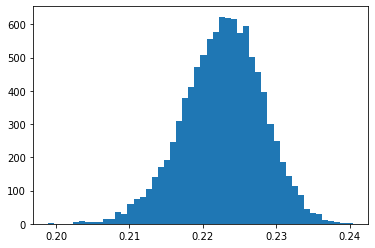

In [77]:
plt.hist(list_preds, bins=50)